In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import time
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
from tqdm import tqdm
import networkx as nx
import random

cuda = True

In [2]:
train = np.load("./data/loc_train_springs5.npy")

print(train.shape)
print(train[0][:][0][1].shape)

(10000, 49, 2, 5)
(5,)


(5, 2, 49)


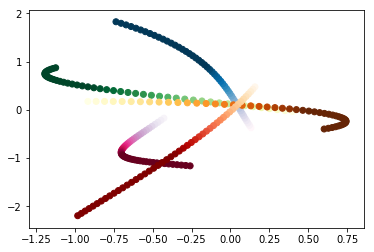

In [3]:
data = train[10]
data = np.transpose(data)
print(data.shape)
maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]
for part in range(5):
    cmap = maps[part](10*np.arange(49))
    plt.scatter(*data[part], c=cmap)

In [4]:
from utils import *
from modules import *

SUFFIX = "_springs5"

train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(
    512, SUFFIX)



In [5]:
def mse_loss(input, target):
    return torch.sum((input - target)**2) / input.data.nelement()

def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []

    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    for batch_idx, (data, relations) in tqdm(enumerate(train_loader)):

        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data), Variable(relations)
        optimizer.zero_grad()
        
        
        logits = model.graph_encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=HARD, hard_prob=HARD_PROB)
        prob = my_softmax(logits, -1)
        
        
        edges = edges.view(edges.shape[0],-1)
        odeparams = model.encoder(edges)
        
        T = torch.linspace(1/50, NUM_TIMESTEPS/50, NUM_TIMESTEPS - 1).cuda()
        output = model.decoder(odeparams, data, T)

        target = data[:, :, 1:, :]
        
        output = output.transpose(0,1).contiguous().view(-1, 48, 5, 4).transpose(1,2)

    
        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)
        loss_mse = mse_loss(output, target)
        loss = loss_mse + loss_kl

        loss.backward(retain_graph=True)
        optimizer.step()

        mse_train.append(loss_mse.item())
        kl_train.append(loss_kl.item())

    mse_val = []
    kl_val = []

    model.encoder.eval()
    model.decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)


        
        logits = model.graph_encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=HARD, hard_prob=HARD_PROB)
        prob = my_softmax(logits, -1)
        
        edges = edges.view(edges.shape[0],-1)
        odeparams = model.encoder(edges)
        
        T = torch.linspace(1/50, NUM_TIMESTEPS/50, NUM_TIMESTEPS - 1).cuda()
        output = model.decoder(odeparams, data, T)
        output = output.transpose(0,1).contiguous().view(-1, 48, 5, 4).transpose(1,2)

        target = data[:, :, 1:, :]

        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)
        loss_mse = mse_loss(output, target)
        loss = loss_mse + loss_kl

        mse_val.append(loss_mse.item())
        kl_val.append(loss_kl.item())
        
        
    print('Epoch: {:04d}'.format(epoch),
          'mse_train: {:.10f}'.format(np.mean(mse_train)),
          'mse_val: {:.10f}'.format(np.mean(mse_val)),
          'kl_train: {:.10f}'.format(np.mean(kl_train)),
          'kl_val: {:.10f}'.format(np.mean(kl_val)),
          'time: {:.4f}s'.format(time.time() - t))
    
    return np.mean(mse_val)

In [6]:
NUM_EPOCHS = 100
NUM_TIMESTEPS = 49 
PREDICTION_STEPS = 50
NUM_ODE_PARAMS = 100

NUM_ATOMS = 5
EDGE_TYPES = 2

VAR = 5e-5
PRIOR =False

TAU = Variable(torch.FloatTensor([5.]), requires_grad=False).cuda()
HARD = True
HARD_PROB = True


off_diag = np.ones([NUM_ATOMS, NUM_ATOMS]) - np.eye(NUM_ATOMS)

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)

rel_rec = torch.FloatTensor(rel_rec).cuda()
rel_send = torch.FloatTensor(rel_send).cuda()


DECODER_HIDDEN = 256
SKIP_FIRST = False
DECODER_DROPOUT = 0.0

In [7]:
class ODEFunc(nn.Module):
    def __init__(self, net, odeparams):
        super().__init__()
        self.odeparams = odeparams
        self.net = net
        
    
    def forward(self, t, y):
        return self.net(torch.cat((y, self.odeparams), -1))
#         y = y.view(-1, 5, 4)
#         res = torch.zeros(*y.shape).cuda()
#         res[:,:,[0,1]] = y[:,:,[2,3]] 
#         return res.view(-1,20)
        
    
class ODEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(40, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, NUM_ODE_PARAMS))
        
    def forward(self, data):
        #data = data.view(data.shape[0], -1)
        return self.net(data)
    
class ODEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2*2*5 + NUM_ODE_PARAMS, 48),
                                 nn.ReLU(),
                                 nn.Linear(48, 48),
                                 nn.Linear(48, 2*2*5))
        
    def forward(self, odeparams, data, t):
        data = data[:, :, 0, :].contiguous().view(data.shape[0], -1)
        return odeint(ODEFunc(self.net, odeparams), data, t)
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.graph_encoder = MLPEncoder(n_in = NUM_TIMESTEPS * 4, n_hid = 256, n_out = 2).cuda()
        self.encoder = ODEEncoder()
        self.decoder = ODEDecoder()
        
    def forward(self, a):
        pass

    
model = Model().cuda()
model

Using factor graph MLP encoder.


/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/modules.py:27: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/modules.py:110: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


Model(
  (graph_encoder): MLPEncoder(
    (mlp1): MLP(
      (fc1): Linear(in_features=196, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): MLP(
      (fc1): Linear(in_features=512, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): MLP(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp4): MLP(
      (fc1): Linear(in_features=768, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [8]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3, )
scheduler = lr_scheduler.StepLR(optimizer, step_size=200,gamma=0.5)

In [9]:
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0
for epoch in range(NUM_EPOCHS):
    val_loss = train(epoch, best_val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
print("Optimization Finished!")
print("Best Epoch: {:04d}".format(best_epoch))



0it [00:00, ?it/s]/home/pierre/Documents/DTU/Deep Learning/Project/discrete_flows/GNN/utils.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)
20it [11:44, 23.46s/it]
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
0it [00:00, ?it/s]

Epoch: 0000 mse_train: 0.0510389248 mse_val: 0.0490363277 kl_train: -1.9195610523 kl_val: -1.9201817513 time: 704.2275s


20it [08:49, 26.69s/it]
0it [00:00, ?it/s]

Epoch: 0001 mse_train: 0.0462812630 mse_val: 0.0444223825 kl_train: -1.9195610523 kl_val: -1.9201817513 time: 529.2352s


20it [10:42, 31.27s/it]
0it [00:00, ?it/s]

Epoch: 0002 mse_train: 0.0407902664 mse_val: 0.0379491858 kl_train: -1.9195610523 kl_val: -1.9201817513 time: 642.8296s


20it [12:18, 35.12s/it]
0it [00:00, ?it/s]

Epoch: 0003 mse_train: 0.0337271109 mse_val: 0.0307292249 kl_train: -1.9195610523 kl_val: -1.9201817513 time: 738.2110s


20it [11:58, 32.42s/it]
0it [00:00, ?it/s]

Epoch: 0004 mse_train: 0.0269264584 mse_val: 0.0245281840 kl_train: -1.9195610523 kl_val: -1.9201817513 time: 718.7192s


3it [01:53, 37.62s/it]

KeyboardInterrupt: 

torch.Size([5, 5, 49, 4])
(5, 4, 49)
(5, 4, 49)
(5, 4, 49)
(5, 4, 49)
(5, 4, 49)


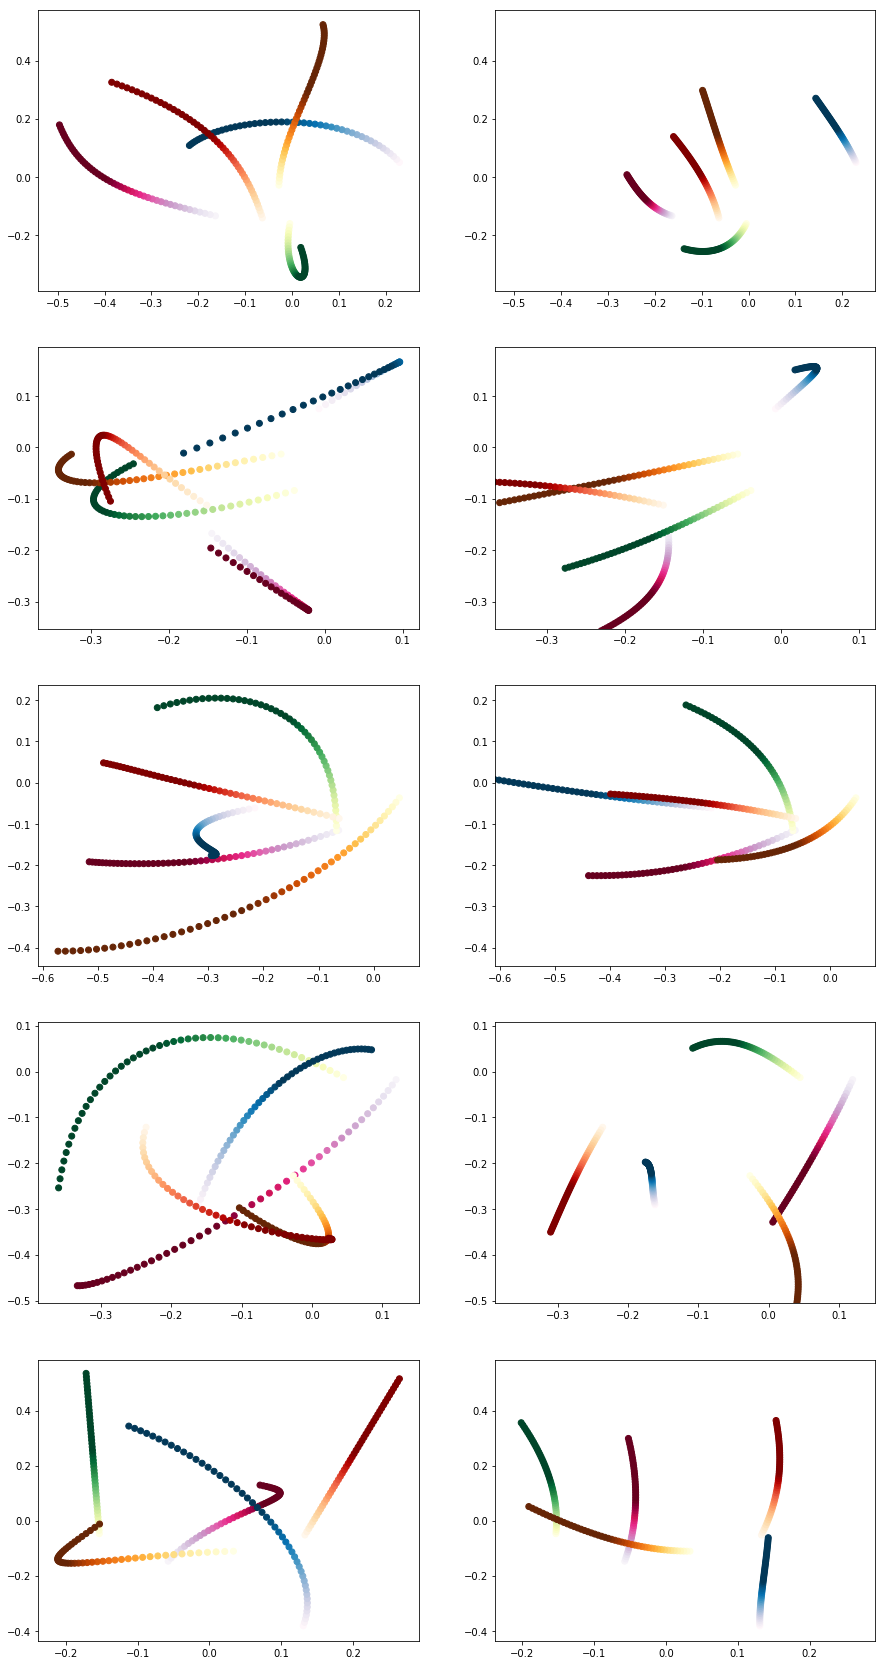

In [10]:
### Prediction of model with right position at each step


f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(train_loader))[0][0:5]

model.encoder.eval()
model.decoder.eval()

x = batch.narrow(2,0,49).cuda()
logits = model.graph_encoder(x, rel_rec, rel_send)
edges = gumbel_softmax(logits, tau=TAU, hard=HARD, hard_prob=HARD_PROB)


edges = edges.view(edges.shape[0],-1)
odeparams = model.encoder(edges)

T = torch.linspace(1/50, NUM_TIMESTEPS/50, NUM_TIMESTEPS).cuda()

prediction = model.decoder(odeparams, x, T).transpose(0,1).view(5, 49, 5, 4).transpose(1,2)
print(prediction.shape)


maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

# maps = ['g', 'b', 'k', 'r', 'c']
x_lim = []
y_lim = []
for i, ax in enumerate(axarr.flat):
    b = torch.transpose(x[i//2], 1,2)
#     print(b.shape)
    if i%2==0:
        for j in range(5):
            cmap = maps[j](10*np.arange(49))
            ax.scatter(b[j][0], b[j][1], c=cmap)
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
#             cmap = maps[j]
#             ax.scatter(b[j][0], b[j][1], c=cmap, alpha=1)
            

    else:
        
        b = torch.transpose(prediction[i//2], 1,2).cpu().detach().numpy()
        print(b.shape)
        
        for j in range(5):
            cmap = maps[j](10*np.arange(49))
            ax.scatter(b[j][0], b[j][1], c=cmap)
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)
#                 cmap = maps[j]
#                 ax.scatter(b[j][0], b[j][1], c=cmap, alpha = 0.05)



    

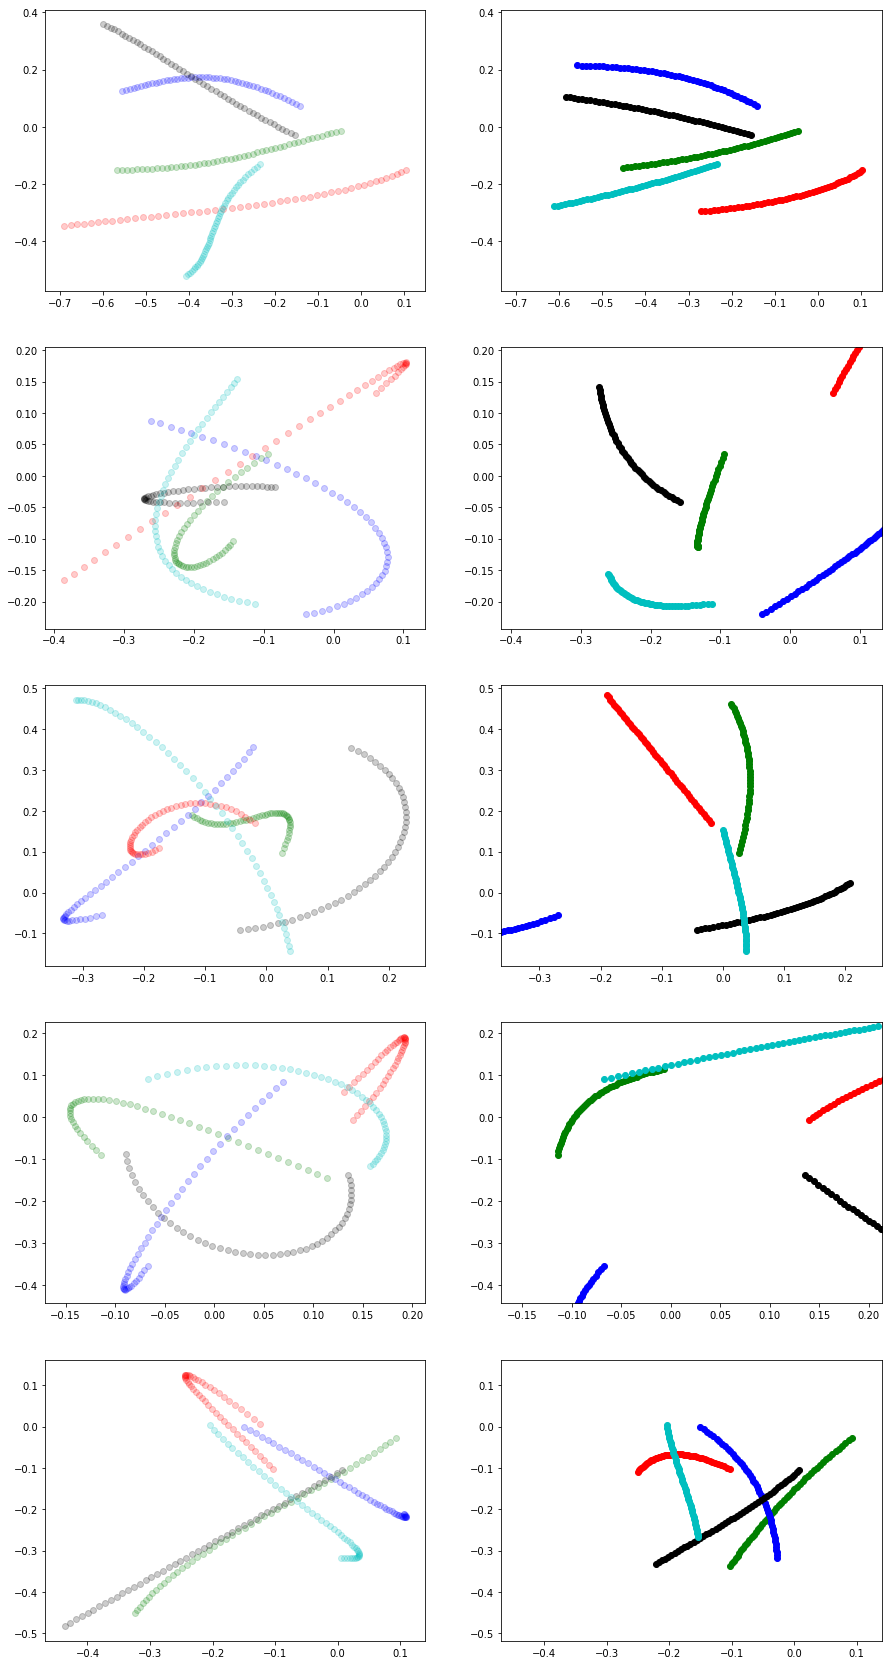

In [11]:
f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(test_loader))[0][10:15]

model.encoder.eval()
model.decoder.eval()

pred_steps = 50 
BURN_IN = False
BURN_IN_STEPS = 30
DYNAMIC_GRAPH = False


x = batch.narrow(2,0,49).cuda()
logits = model.graph_encoder(x, rel_rec, rel_send)
edges = gumbel_softmax(logits, tau=TAU, hard=HARD, hard_prob=HARD_PROB)

edges = edges.view(edges.shape[0],-1)
odeparams = model.encoder(edges)

T = torch.linspace(1/50, NUM_TIMESTEPS/50, NUM_TIMESTEPS).cuda()
output = model.decoder(odeparams, x, T)

output = output.transpose(0,1).view(5, 49, 5, 4).transpose(1,2)


# maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

maps = ['g', 'b', 'k', 'r', 'c']

x_lim = []
y_lim = []
for i, ax in enumerate(axarr.flat):
    b = torch.transpose(batch[i//2], 1,2)
#     print(b.shape)
    if i%2==0:
        for j in range(5):
#             cmap = maps[j](10*np.arange(49))
#             ax.scatter(b[j][0], b[j][1], c=cmap)
            
            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
#             ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            

    else:
        
        b = torch.transpose(batch[i//2], 1,2).cpu().detach().numpy()
        d = torch.transpose(output[i//2], 1,2).cpu().detach().numpy()

        for j in range(5):
#             cmap = maps[j](10*np.arange(48))
#             ax.scatter(b[j][0], b[j][1], c=cmap)  

            cmap = maps[j]
#             ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 1)
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)



    

/home/pierre/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])
torch.Size([5, 20, 1])


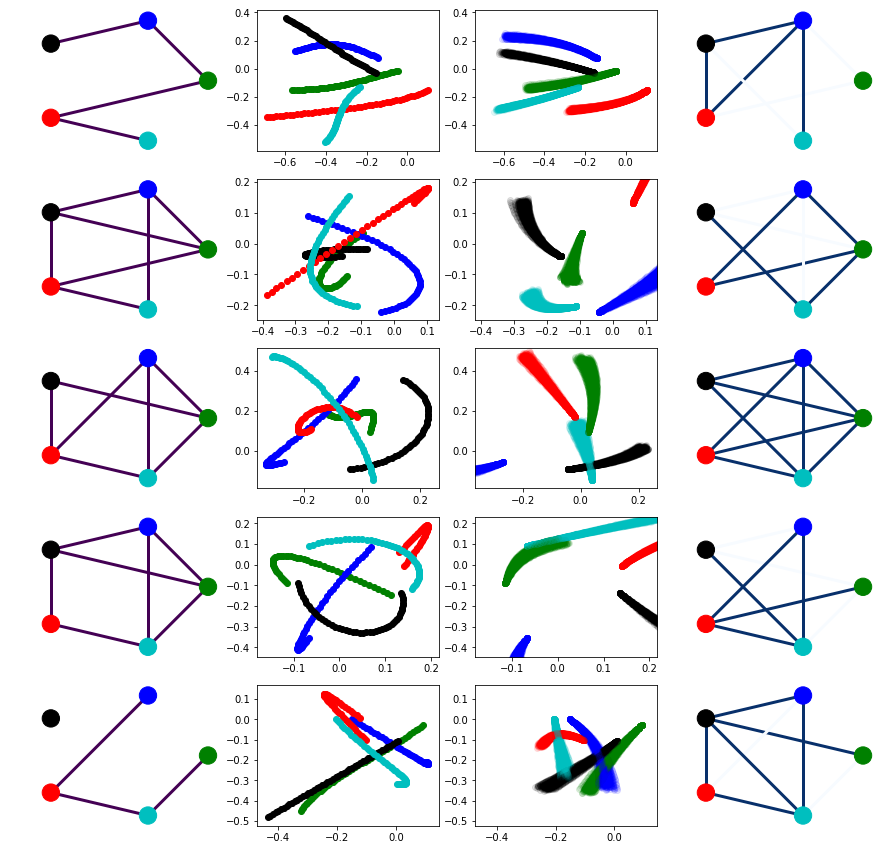

In [12]:
f, axarr = plt.subplots(5, 4, figsize=(15, 15))
batch_complete_data = next(iter(test_loader))
batch = batch_complete_data[0][10:15]
edges_b = batch_complete_data[1][10:15]
batch_edges = edges_b.view((5,5,4)).numpy()

model.encoder.eval()
model.decoder.eval()

pred_steps = 50 

n_samples = 50

x = batch.narrow(2,0,49).cuda()
logits = model.graph_encoder(x, rel_rec, rel_send)


inputs = batch.transpose(1, 2)
outputs_list = []
edges_samples = []
for sample in range(n_samples):

    edges = gumbel_softmax(logits, tau=TAU*10, hard=True, hard_prob=True)
    edges_samples.append(edges.cpu().detach())
    edges = edges.view(edges.shape[0],-1)
    odeparams = model.encoder(edges)

    T = torch.linspace(1/50, NUM_TIMESTEPS/50, NUM_TIMESTEPS).cuda()
    output = model.decoder(odeparams, x, T)

    output = output.transpose(0,1).view(5, 49, 5, 4).transpose(1,2)

    outputs_list.append(output.cpu().detach())
    edges_samples.append(edges.cpu().detach())

# maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

maps = ['g', 'b', 'k', 'r', 'c']

x_lim = []
y_lim = []


for i, ax in enumerate(axarr.flat):
    b = torch.transpose(batch[i//4], 1,2)
#     print(b.shape)
    if i%4 ==0:

        edges_list = []

        for k,part in enumerate(batch_edges[i//4]):
            l = np.insert(part,k,0)
            edges_list.append(np.array(l))

        edges_list = np.array(edges_list)

        graph = nx.Graph()
        if SUFFIX == "_springs5":
            graph = nx.from_numpy_matrix(edges_list)
            type_edges = [edges_list[a][b] for (a,b) in graph.edges()]
            nx.draw(graph,
                    ax=ax, 
                    pos=nx.shell_layout(graph),
                    node_color=maps, 
                    edge_color=type_edges,
                    width = 3)
        elif SUFFIX == "_charged5":
            edges_list[edges_list == 0] = -1
            edges_list = edges_list + np.eye(edges_list.shape[0])
            graph = nx.from_numpy_matrix(edges_list)
            type_edges = [edges_list[a][b] for (a,b) in graph.edges()]

            nx.draw(graph,
                    ax=ax, 
                    pos=nx.shell_layout(graph),
                    node_color=maps,
                    edge_cmap=cm.bwr, 
                    edge_color=type_edges,
                    width = 3)

    elif i%4==1:
        for j in range(5):
            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 1)
            #ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()


    elif i%4==2:

        b = torch.transpose(batch[i//4], 1,2).cpu().detach().numpy()
        for j in range(5):
            cmap = maps[j]
            #ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
        for output in outputs_list:
            d = torch.transpose(output[i//4], 1,2).numpy()
            for j in range(5):
                cmap = maps[j]
                ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 0.1)
                ax.set_xlim(x_lim)
                ax.set_ylim(y_lim) 
    else:
        edges_list = []
        resized_edges = edges_samples[0].narrow(-1,0,1) #show the graph of a random sample
        for k,part in enumerate(resized_edges.view(5,5,4,-1).numpy()[i//4]):
            l = np.insert(part,k,0)
            edges_list.append(np.array(l))

        edges_list = np.array(edges_list)
        if SUFFIX == "_springs5":
            graph = nx.Graph()
            graph = nx.from_numpy_matrix(edges_list)
            proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]
            nx.draw(graph, 
                    ax=ax, 
                    pos=nx.shell_layout(graph), 
                    node_color=maps, 
                    edge_cmap=cm.Blues, 
                    edge_color=proba_edges,
                    edge_vmin=0, 
                    edge_vmax=1,
                    width = 3)
        else:
            graph = nx.Graph()
            edges_list[edges_list == 0] = 1e-5
            edges_list = edges_list + np.eye(edges_list.shape[0])

            graph = nx.from_numpy_matrix(edges_list)
            proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]

            nx.draw(graph, 
                    ax=ax, 
                    pos=nx.shell_layout(graph), 
                    node_color=maps, 
                    edge_cmap=cm.bwr, 
                    edge_vmin=0, 
                    edge_vmax=1,
                    edge_color=proba_edges,
                    width = 3)





In [ ]:
f, axarr = plt.subplots(5, 4, figsize=(15, 15))
batch_complete_data = next(iter(test_loader))
batch = batch_complete_data[0][10:15]
edges_b = batch_complete_data[1][10:15]
batch_edges = edges_b.view((5,5,4)).numpy()

model.encoder.eval()
model.decoder.eval()

pred_steps = 50 

n_samples = 50


inputs = batch.transpose(1, 2)
outputs_list = []
edges_samples = []
for sample in range(n_samples):

    edges = gumbel_softmax(logits, tau=TAU*10, hard=True, hard_prob=True)
    edges_samples.append(edges.cpu().detach())
    edges = edges.view(edges.shape[0],-1)
    odeparams = model.encoder(edges)

    T = torch.linspace(1/50, NUM_TIMESTEPS/50, NUM_TIMESTEPS).cuda()
    output = model.decoder(odeparams, x, T)

    output = output.transpose(0,1).view(5, 49, 5, 4).transpose(1,2)

    outputs_list.append(output.cpu().detach())
    edges_samples.append(edges.cpu().detach())

# maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

maps = ['g', 'b', 'k', 'r', 'c']

x_lim = []
y_lim = []


for i, ax in enumerate(axarr.flat):
    b = torch.transpose(batch[i//4], 1,2)
#     print(b.shape)
    if i%4 ==0:

        edges_list = []

        for k,part in enumerate(batch_edges[i//4]):
            l = np.insert(part,k,0)
            edges_list.append(np.array(l))

        edges_list = np.array(edges_list)

        graph = nx.Graph()
        if SUFFIX == "_springs5":
            graph = nx.from_numpy_matrix(edges_list)
            type_edges = [edges_list[a][b] for (a,b) in graph.edges()]
            nx.draw(graph,
                    ax=ax, 
                    pos=nx.shell_layout(graph),
                    node_color=maps, 
                    edge_color=type_edges,
                    width = 3)
        elif SUFFIX == "_charged5":
            edges_list[edges_list == 0] = -1
            edges_list = edges_list + np.eye(edges_list.shape[0])
            graph = nx.from_numpy_matrix(edges_list)
            type_edges = [edges_list[a][b] for (a,b) in graph.edges()]

            nx.draw(graph,
                    ax=ax, 
                    pos=nx.shell_layout(graph),
                    node_color=maps,
                    edge_cmap=cm.bwr, 
                    edge_color=type_edges,
                    width = 3)

    elif i%4==1:
        for j in range(5):
            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 1)
            #ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()


    elif i%4==2:

        b = torch.transpose(batch[i//4], 1,2).cpu().detach().numpy()
        for j in range(5):
            cmap = maps[j]
            #ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
        for output in outputs_list:
            d = torch.transpose(output[i//4], 1,2).numpy()
            for j in range(5):
                cmap = maps[j]
                ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 0.1)
                ax.set_xlim(x_lim)
                ax.set_ylim(y_lim) 
    else:
        edges_list = []
        resized_edges = edges_samples[0].narrow(-1,0,1) #show the graph of a random sample1
        for k,part in enumerate(resized_edges.view(5,5,4,-1).numpy()[i//4]):
            l = np.insert(part,k,0)
            edges_list.append(np.array(l))

        edges_list = np.array(edges_list)
        if SUFFIX == "_springs5":
            graph = nx.Graph()
            graph = nx.from_numpy_matrix(edges_list)
            proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]
            nx.draw(graph, 
                    ax=ax, 
                    pos=nx.shell_layout(graph), 
                    node_color=maps, 
                    edge_cmap=cm.Blues, 
                    edge_color=proba_edges,
                    edge_vmin=0, 
                    edge_vmax=1,
                    width = 3)
        else:
            graph = nx.Graph()
            edges_list[edges_list == 0] = 1e-5
            edges_list = edges_list + np.eye(edges_list.shape[0])

            graph = nx.from_numpy_matrix(edges_list)
            proba_edges = [edges_list[a][b] for (a,b) in graph.edges()]

            nx.draw(graph, 
                    ax=ax, 
                    pos=nx.shell_layout(graph), 
                    node_color=maps, 
                    edge_cmap=cm.bwr, 
                    edge_vmin=0, 
                    edge_vmax=1,
                    edge_color=proba_edges,
                    width = 3)



